# Análise Exploratóra - PCA e Clustering

## Sobre este notebook

O objetivo deste notebook é identificar a distribuição das variáveis socioeconômicas dos municípios e agrupá-los em clusters a a partir de suas similaridades.

Utilizamos o PCA para reduzir a dimensionalidade do conjunto de dados e em seguida aplicamos o algoritmo K-Means para realizar o agrupamento. 

Pelo método do silhouette score, chegamos ao valor ótimo de k = 2. Utilizamos o algoritmo Boruta no dataset original para prever o valor dos clusters e selecionar o conjunto ótimo de features. Em seguida, rodamos o PCA no conjunto de dados com a melhores features e realizamos uma nova análise de clustering. A segunda análise indicou novamente um número ótimo de k = 2, porém com um silhouette score maior.

Após uma análise minunciosa, identificamos que dividir o conjunto de dados em 4 clusters era

# 1) Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from yellowbrick.cluster import silhouette_visualizer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

warnings.filterwarnings("ignore")
sns.set_style("white")

# 2) Coleta dos Dados

In [2]:
df = pd.read_csv(r'../Dados/Tabela_final/tabela_final.csv')
df

,IBGE7,UF,NOME,LATITUDE,LONGITUDE,DIST_EF_PUB,DIST_EM_PUB,IDEB_AI,IDEB_AF,DOCSUP_EF_PUB,...,T_ANALF18M,T_ANALF25A29,T_ANALF25M,RDPC,QUAL_MED_AGUA,TRANSPORT_COST,TOT_ESC_POR_POP,TOT_MAT_POR_POP,DIST_CAPITAL,CAPITAL_PROX
0,2700300,AL,ARAPIRACA,-9.75487,-36.6615,28.884,43.100,4.580,3.624,54.40,...,24.10,11.76,28.61,423.28,62.486900,24042.166072,0.000433,0.245423,102.025981,MACEIO
1,2700706,AL,BATALHA,-9.67420,-37.1330,31.100,35.892,4.544,3.632,12.62,...,33.44,20.53,40.54,265.62,62.486900,24257.110578,0.001200,0.384829,137.500525,ARACAJU
2,2700904,AL,BELO MONTE,-9.82272,-37.2770,36.412,54.792,3.928,3.044,27.12,...,41.81,30.29,49.99,187.77,52.964055,24226.863743,0.002235,0.298063,122.950205,ARACAJU
3,2701209,AL,CACIMBINHAS,-9.40121,-36.9911,38.284,40.720,4.164,3.324,49.04,...,43.81,30.14,51.12,259.72,62.486900,24358.206538,0.001102,0.419781,140.854338,MACEIO
4,2701605,AL,CANAPI,-9.11932,-37.5967,31.024,38.636,4.584,3.580,20.84,...,44.16,28.31,51.97,183.83,74.933851,24734.221802,0.002032,0.366838,207.272744,ARACAJU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,2806008,SE,RIBEIROPOLIS,-10.53570,-37.4380,35.080,41.796,4.032,3.472,64.68,...,30.60,11.60,36.26,357.17,65.680219,23891.778664,0.000692,0.211261,57.971219,ARACAJU
1257,2807006,SE,SAO MIGUEL DO ALEIXO,-10.38470,-37.3836,33.148,47.912,3.940,3.116,62.08,...,37.03,18.32,44.72,279.25,65.680219,23954.902605,0.002280,0.196098,67.763439,ARACAJU
1258,2807105,SE,SIMAO DIAS,-10.73870,-37.8097,38.340,45.756,4.200,3.364,61.38,...,28.90,14.39,34.16,293.99,65.680219,23918.838452,0.001108,0.254938,83.224418,ARACAJU
1259,2807303,SE,TELHA,-10.20640,-36.8818,31.636,47.600,4.384,3.520,45.66,...,29.62,14.00,35.41,268.17,62.486900,23869.921712,0.001539,0.222838,80.736011,ARACAJU


# 2) Análise Exploratória

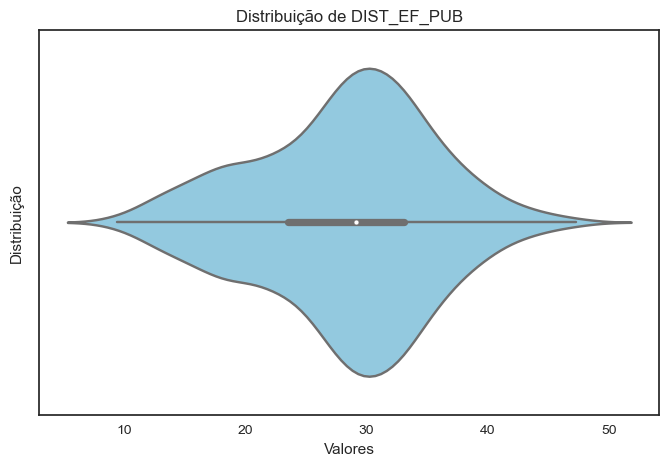

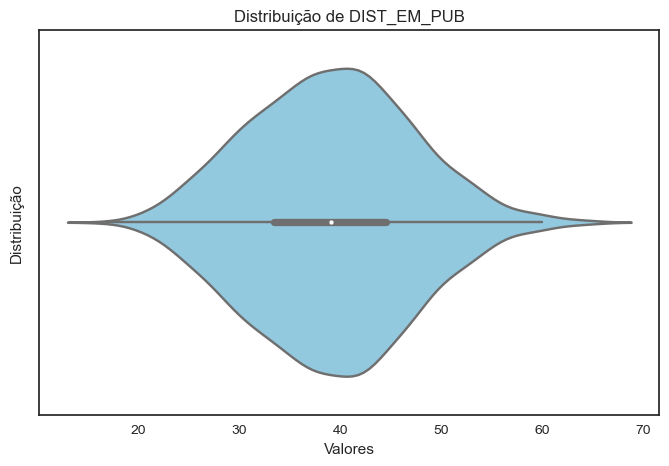

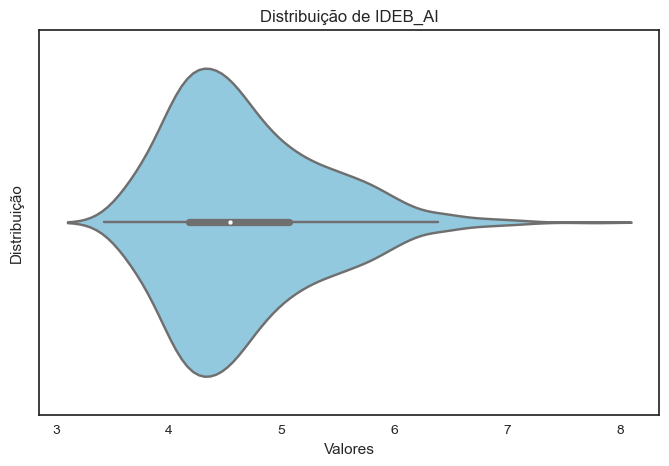

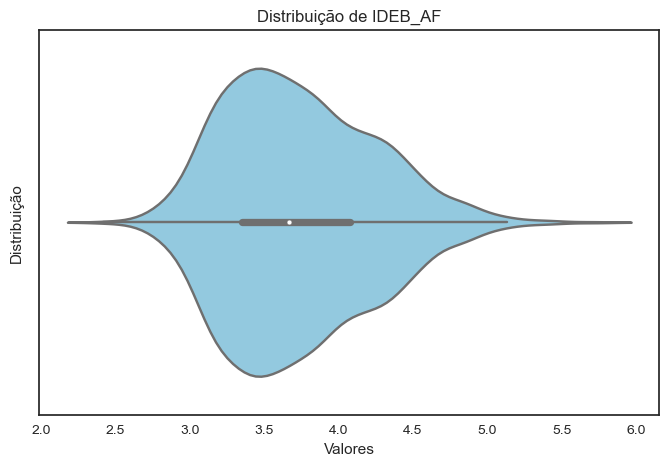

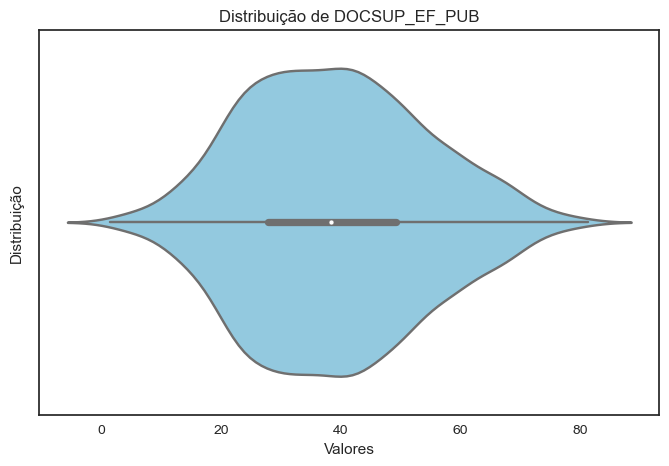

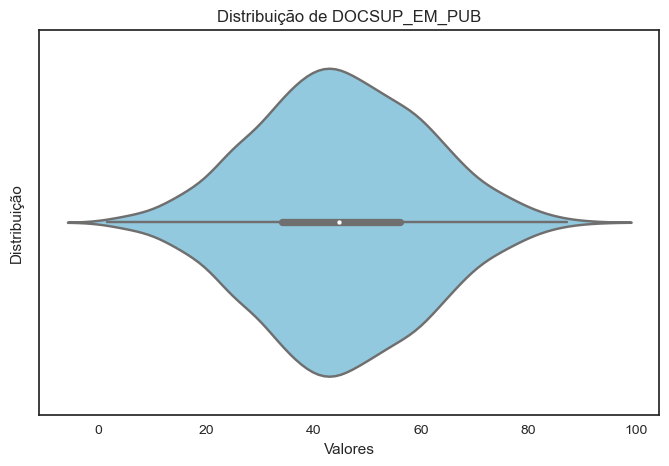

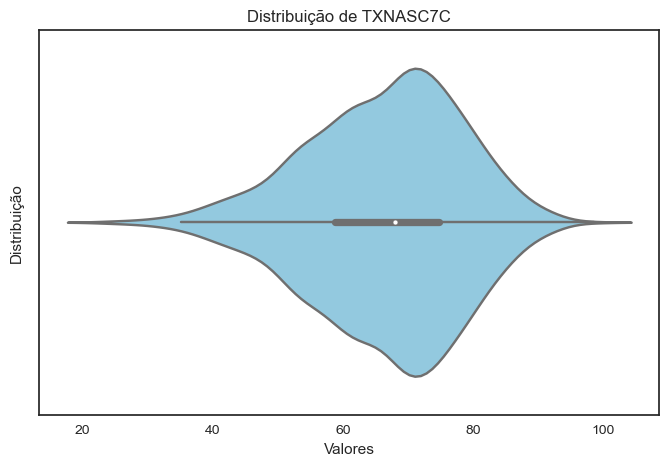

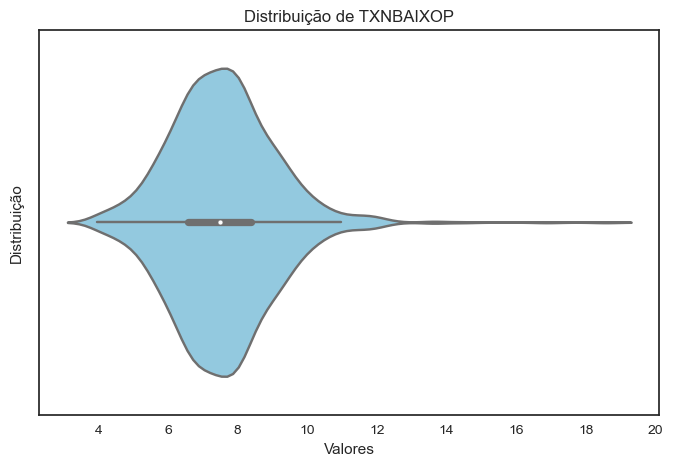

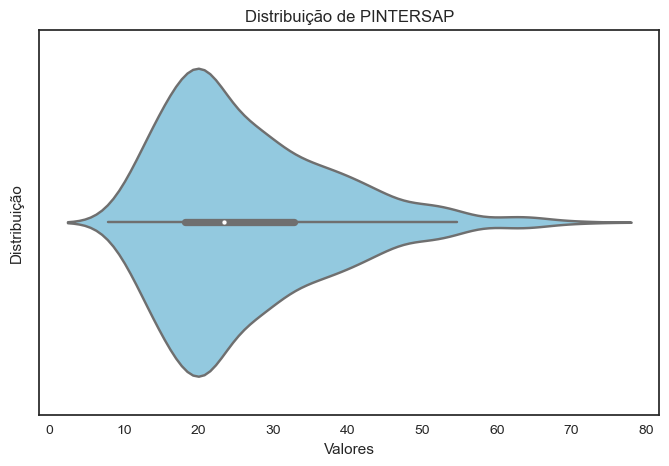

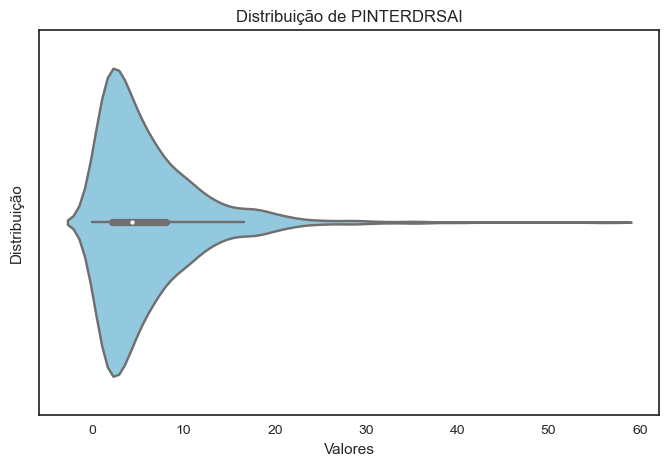

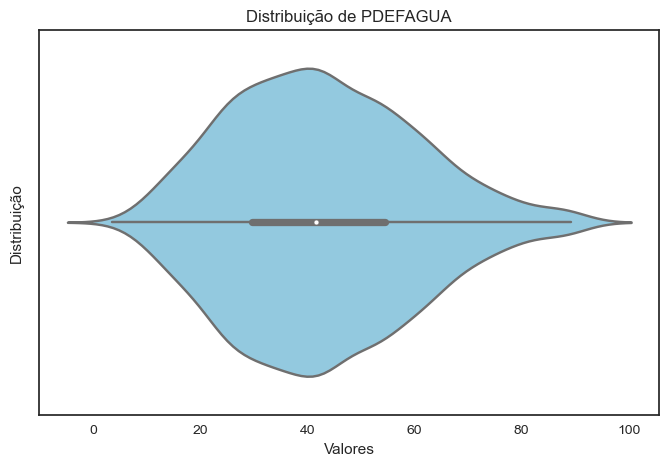

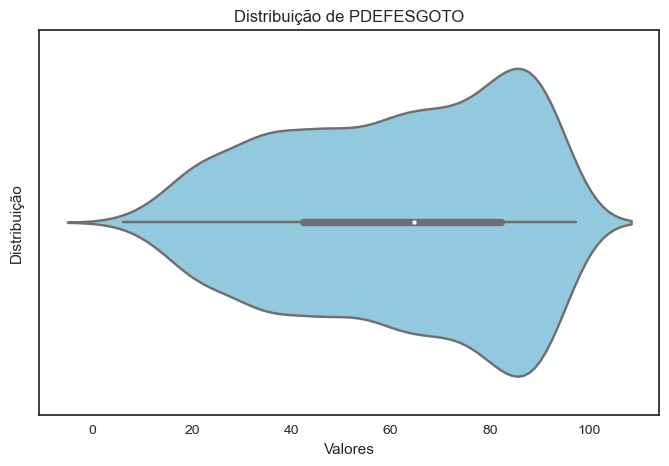

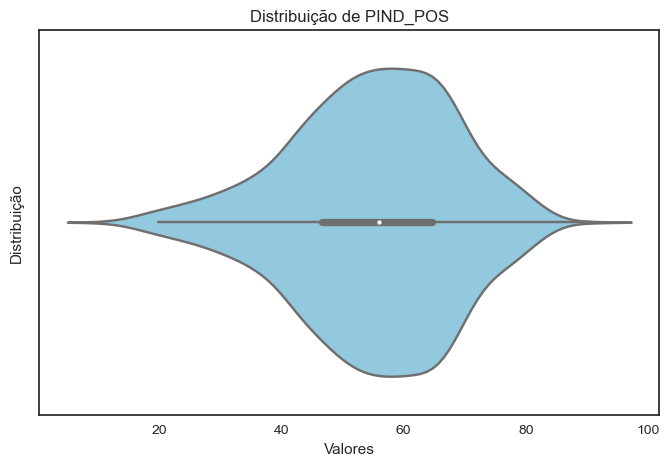

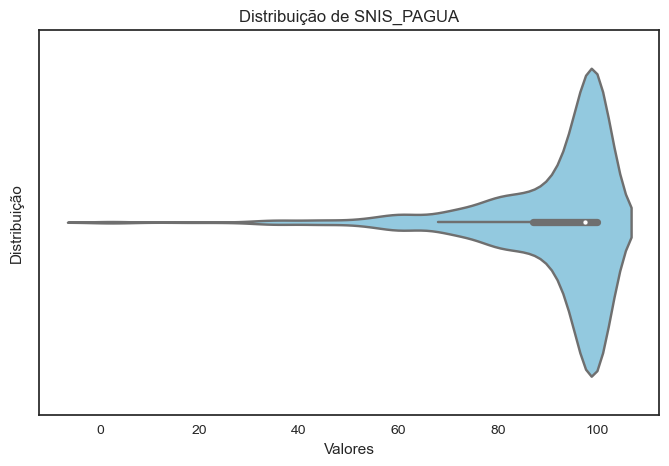

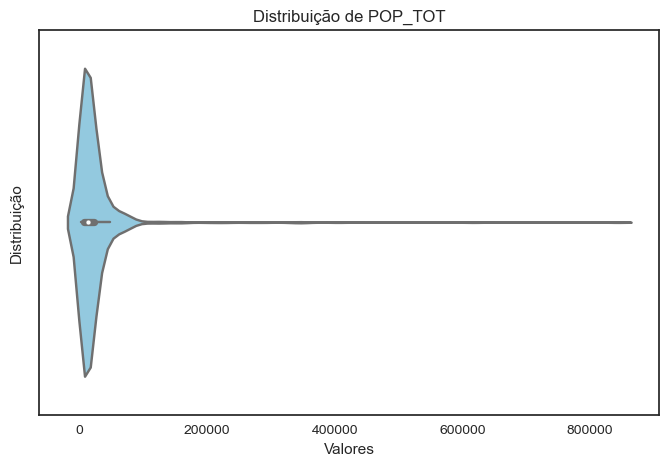

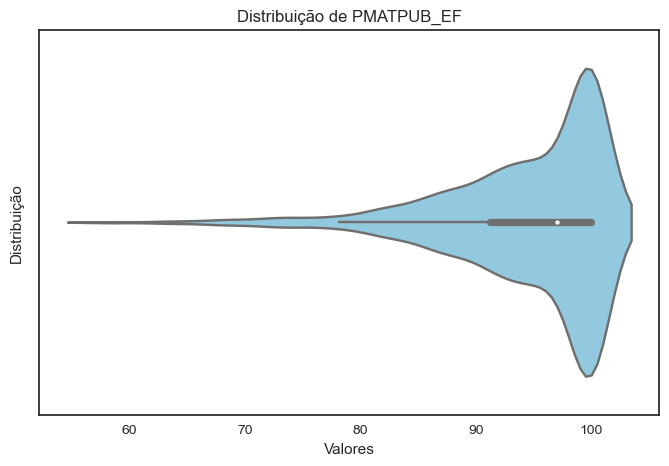

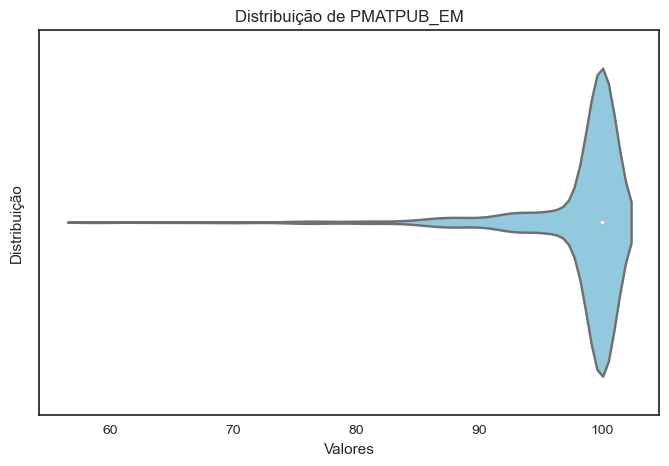

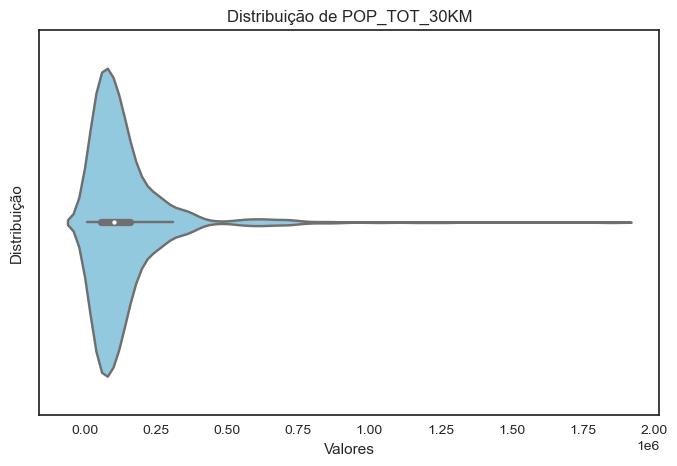

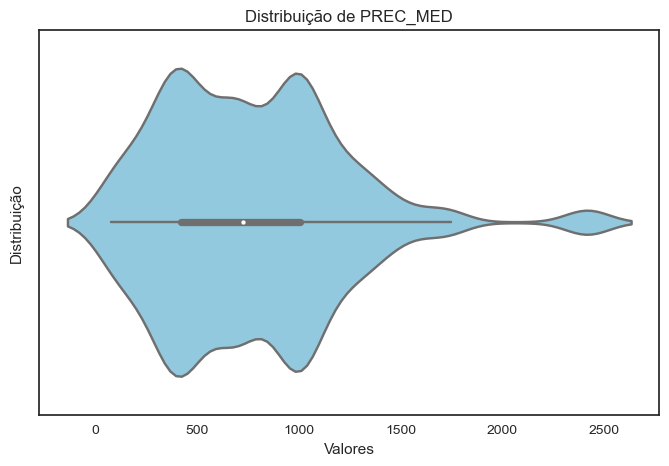

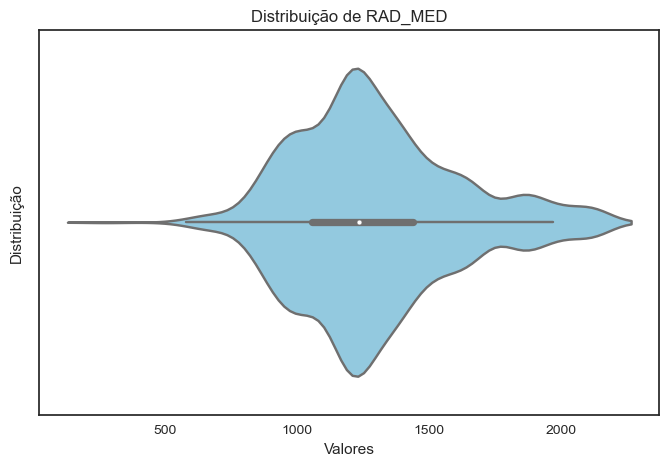

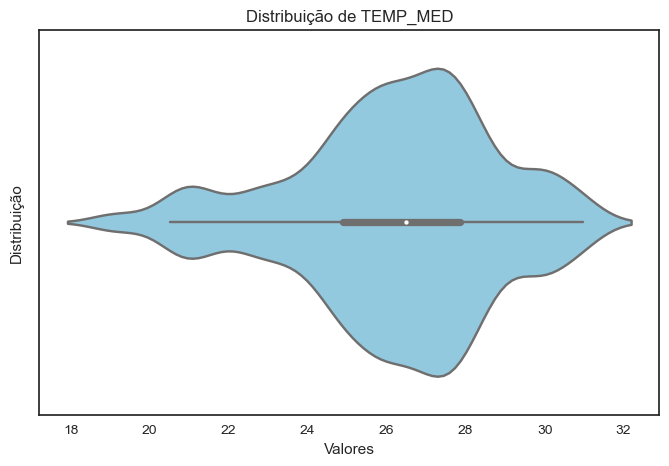

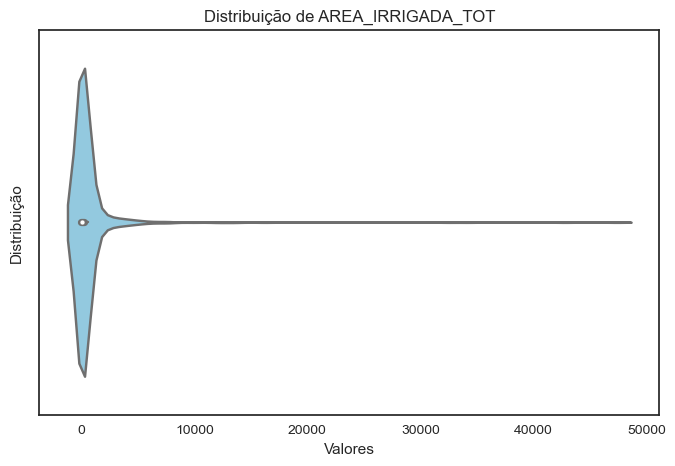

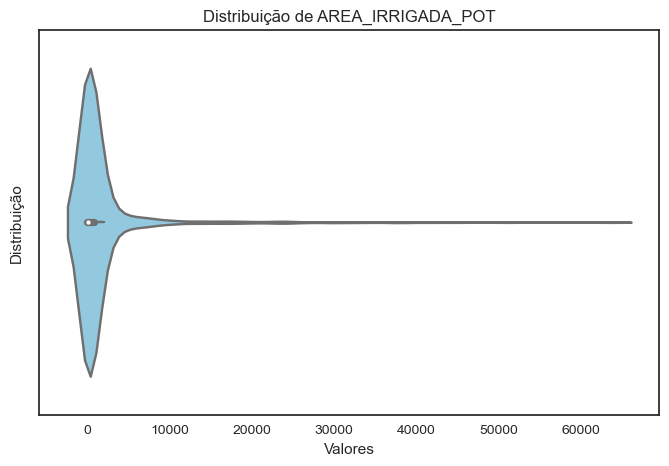

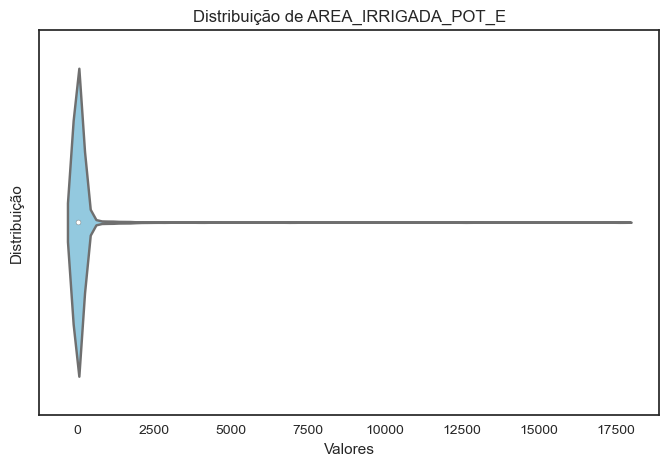

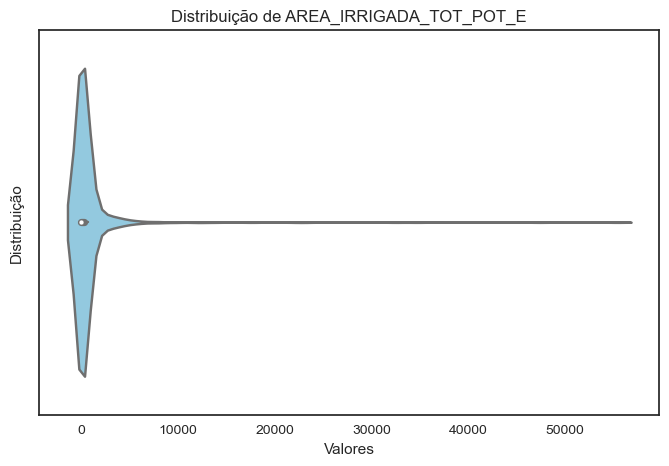

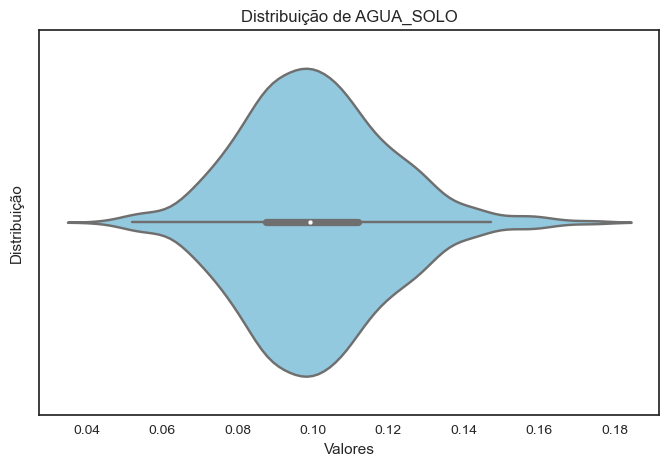

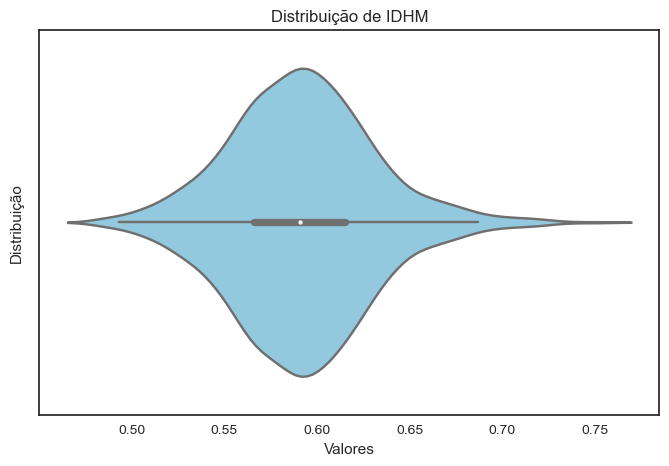

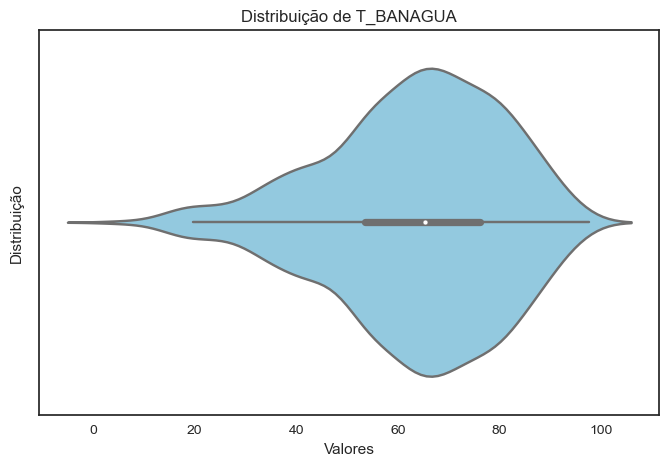

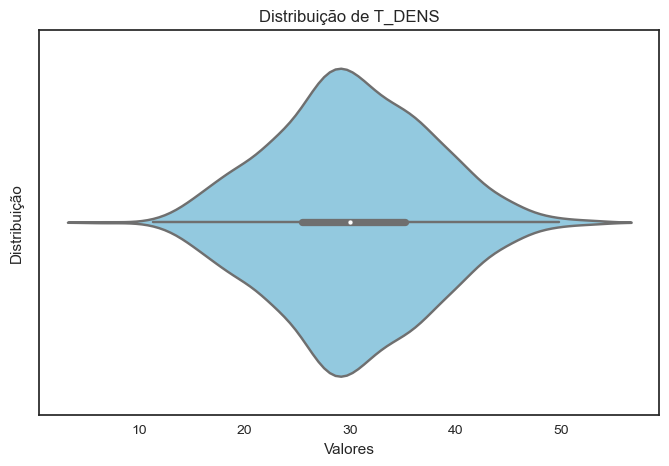

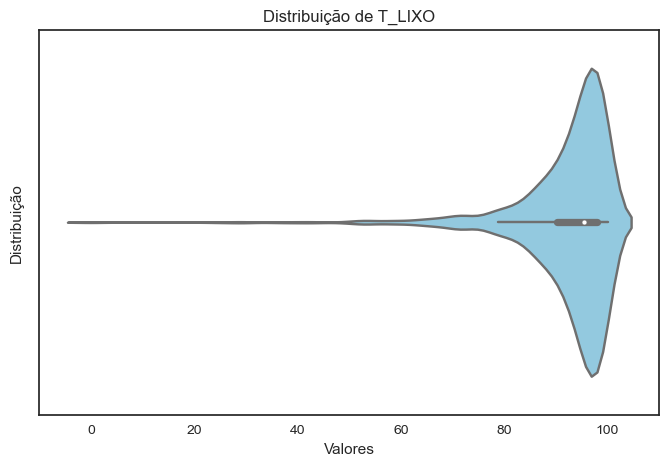

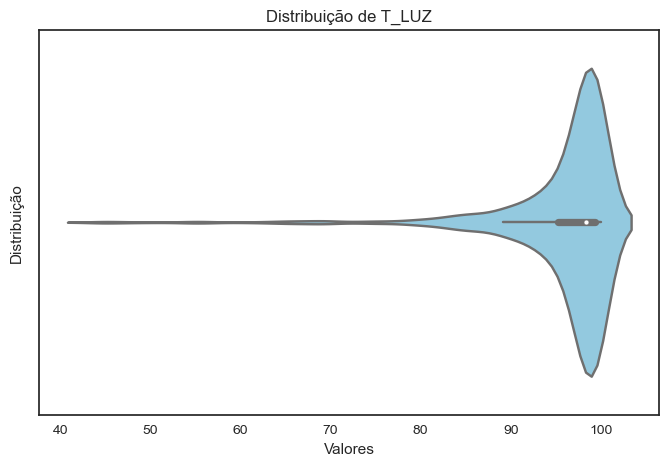

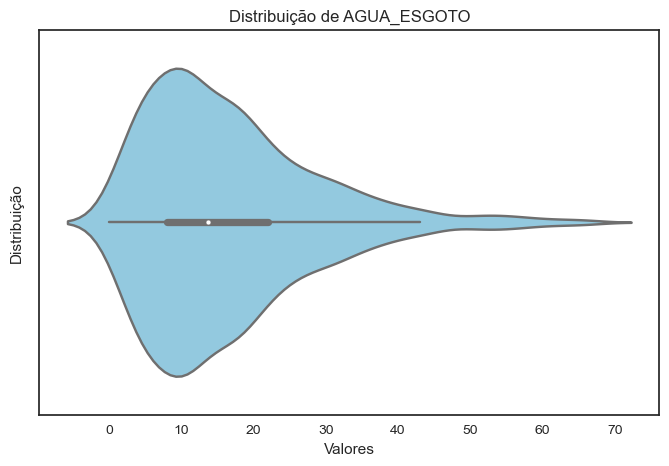

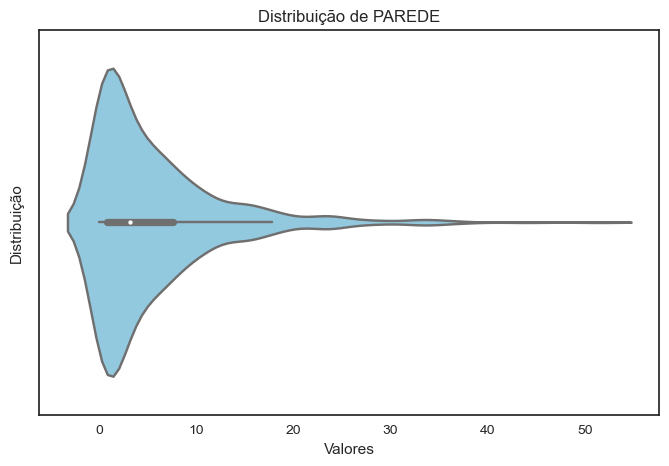

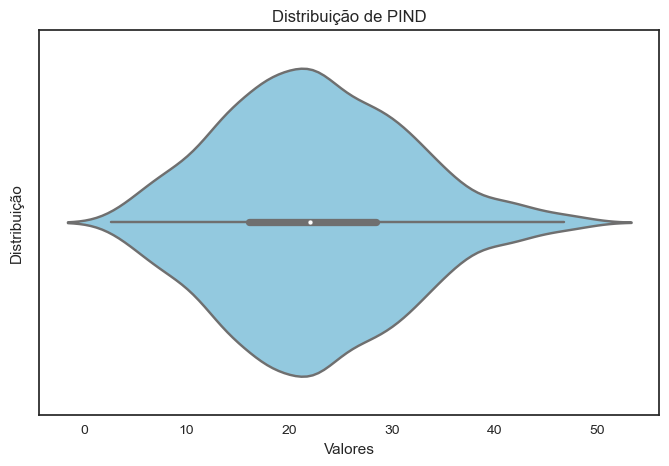

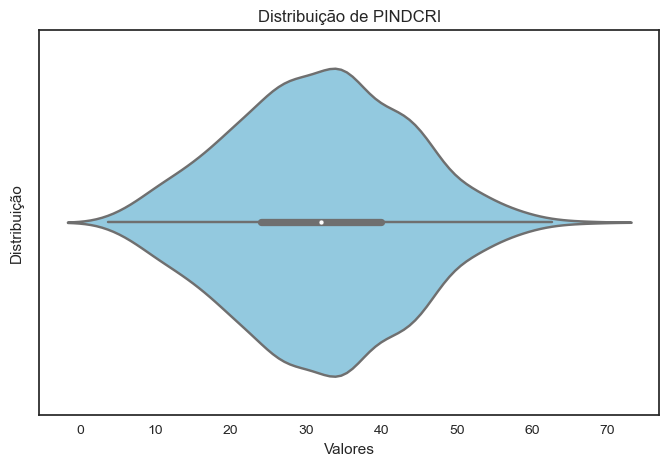

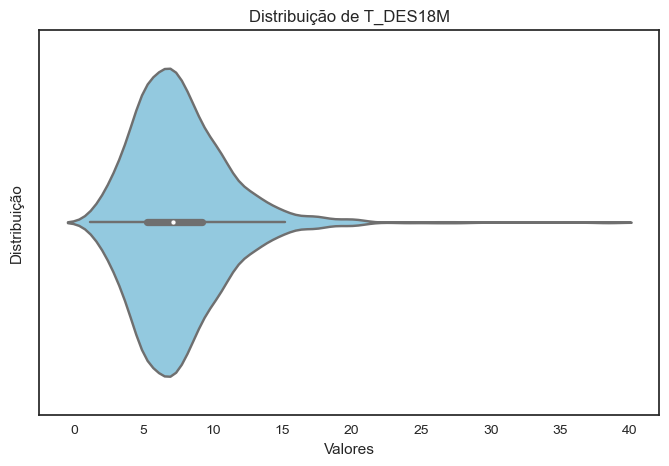

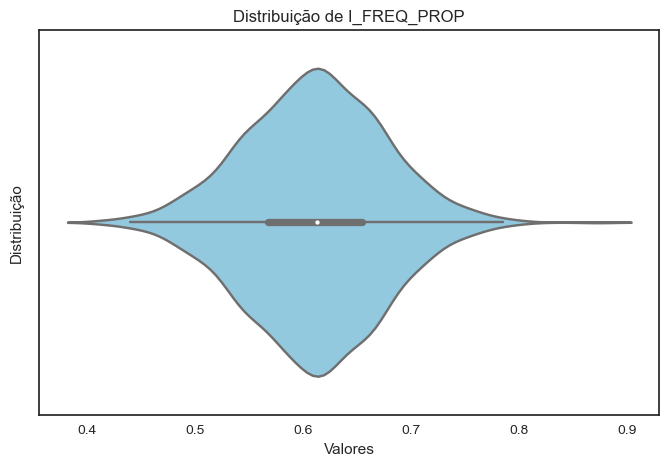

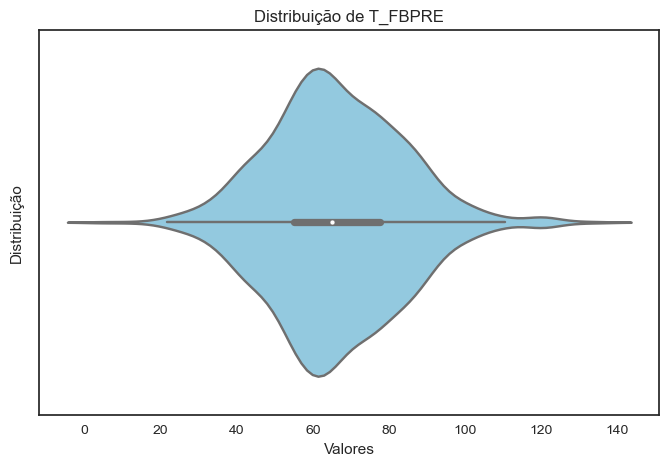

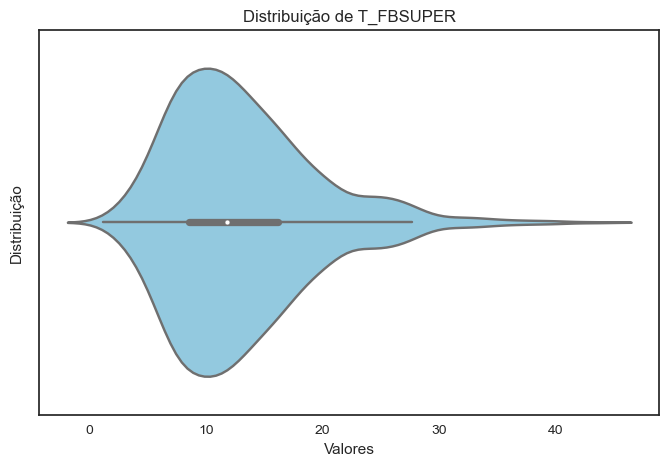

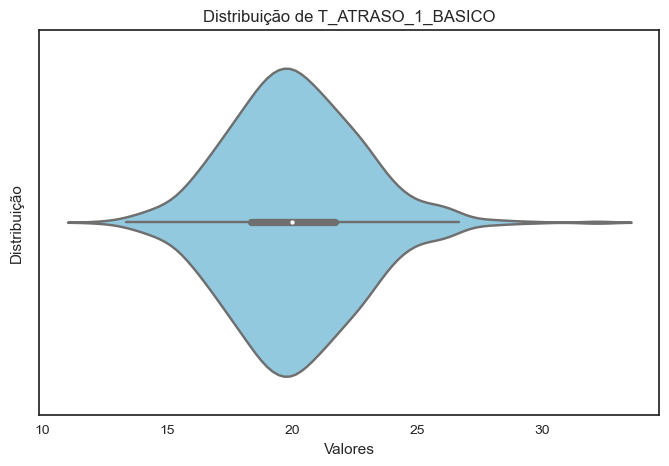

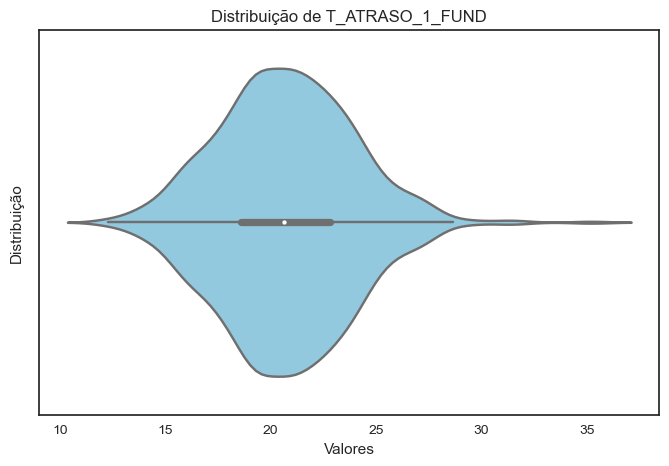

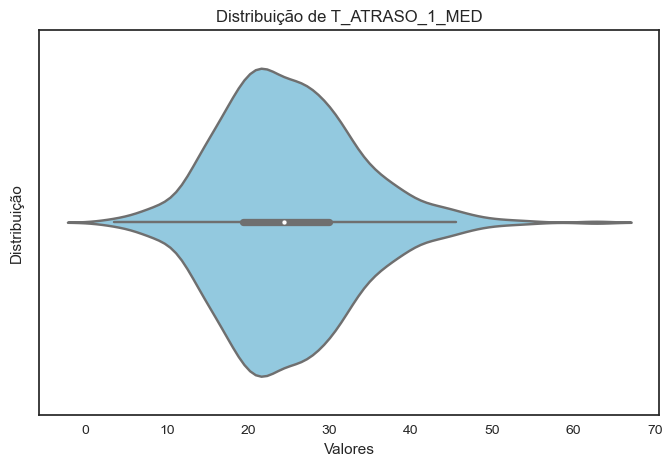

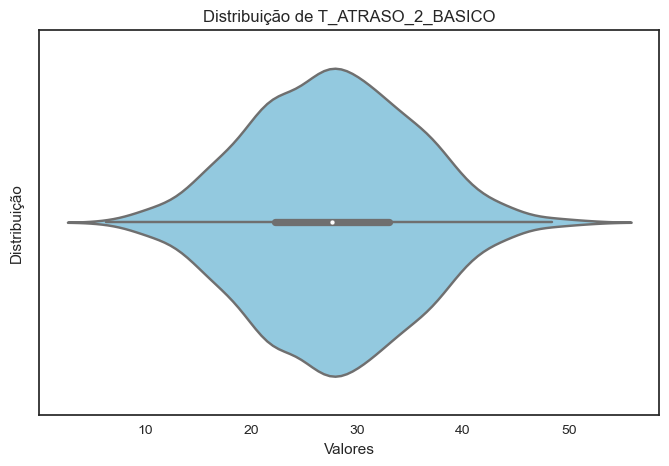

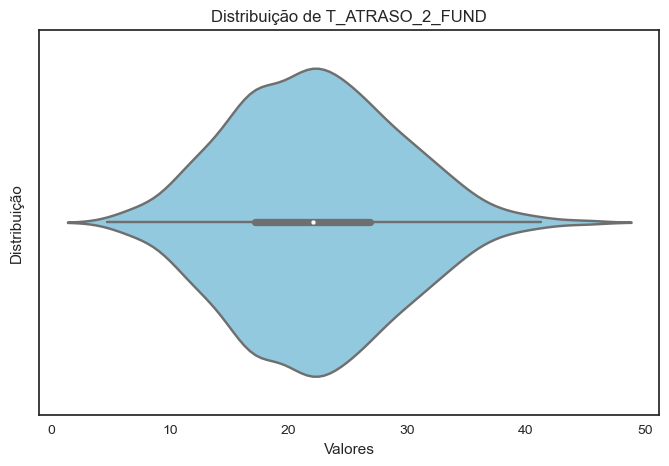

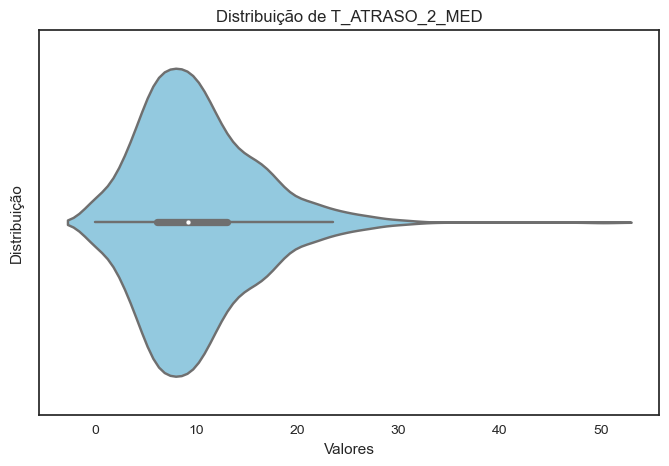

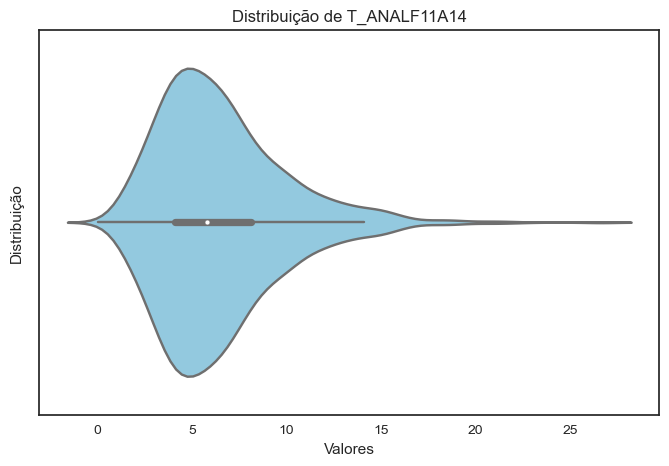

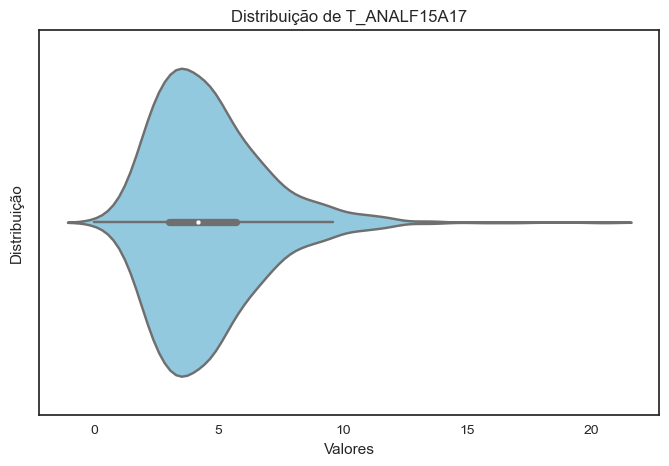

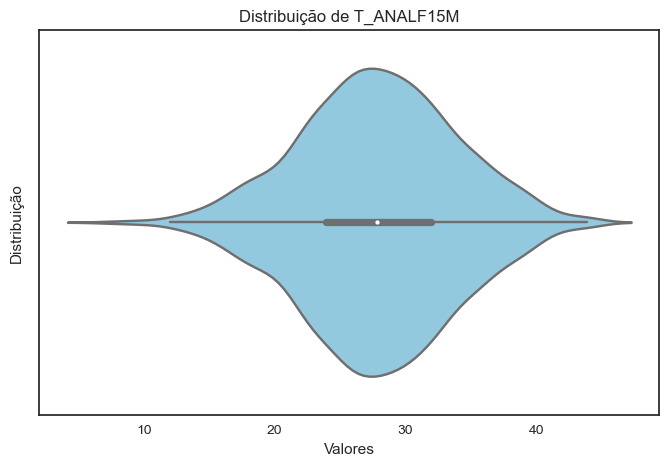

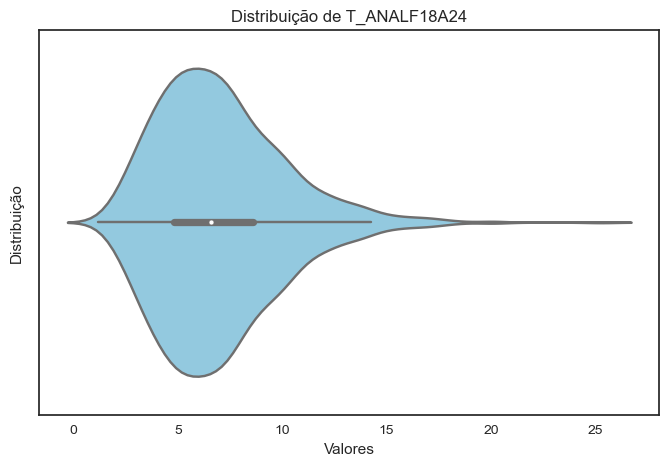

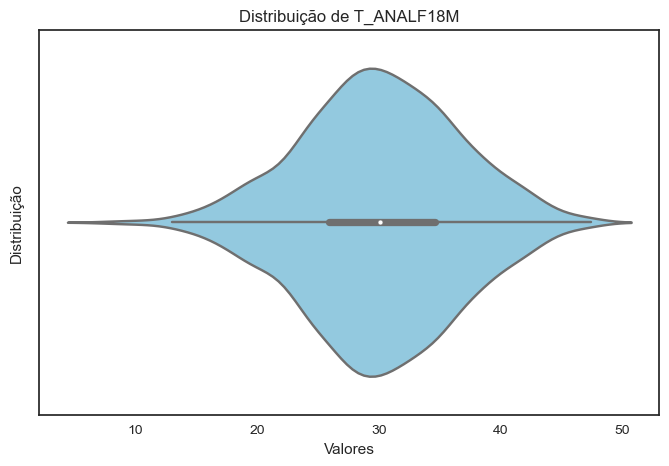

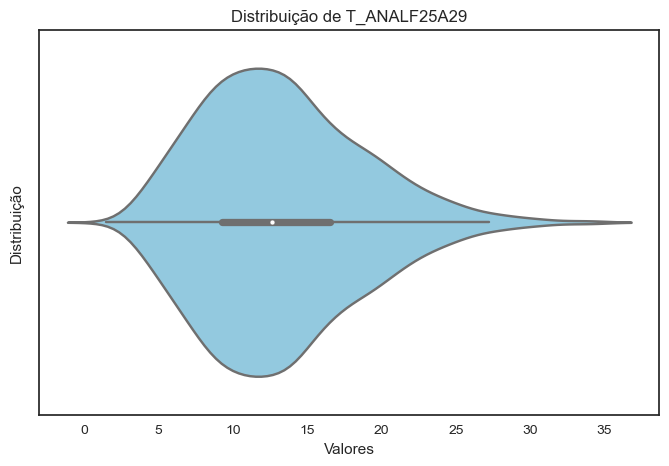

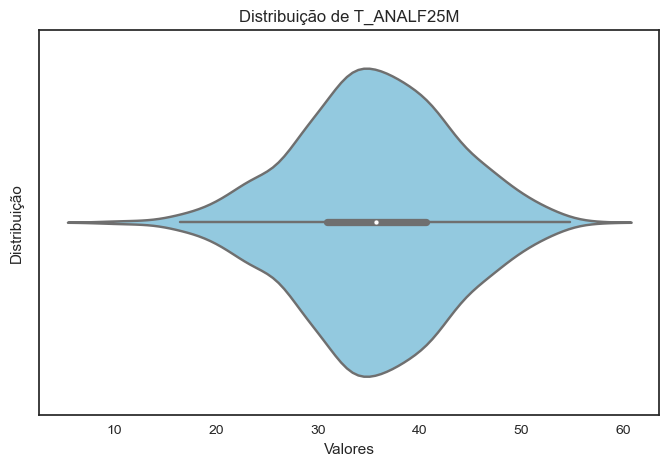

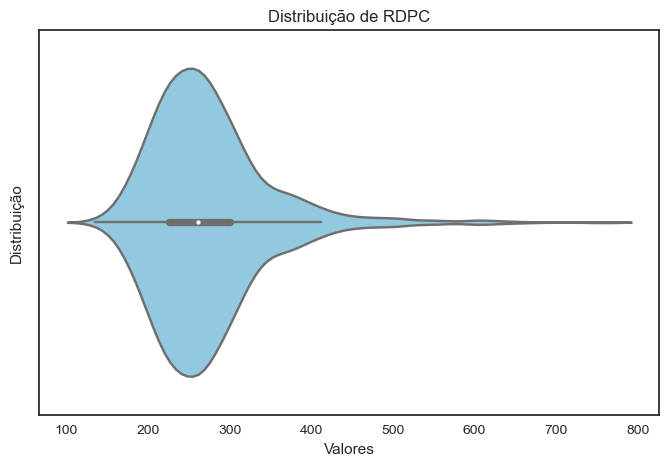

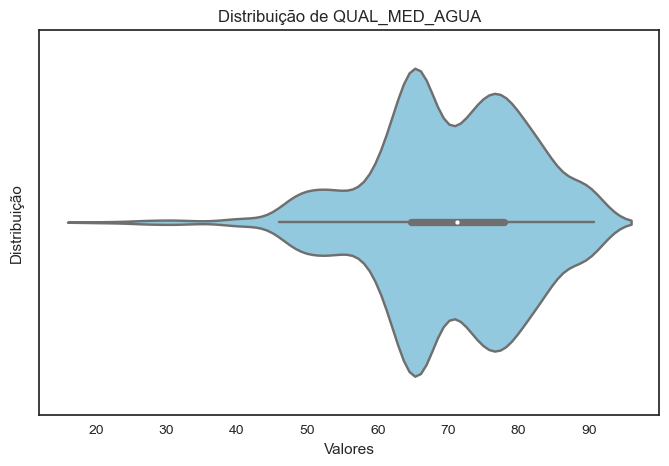

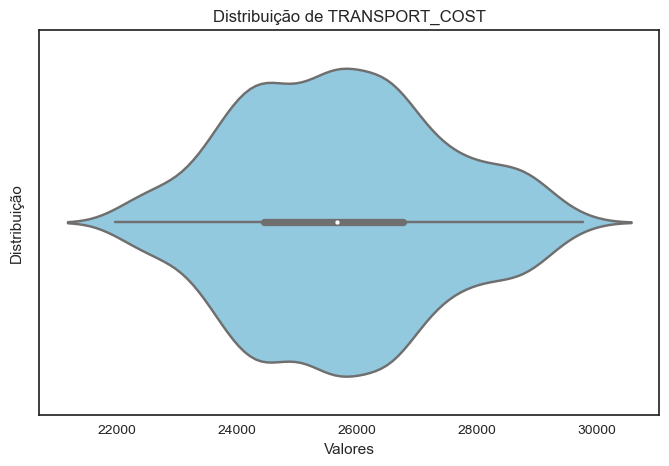

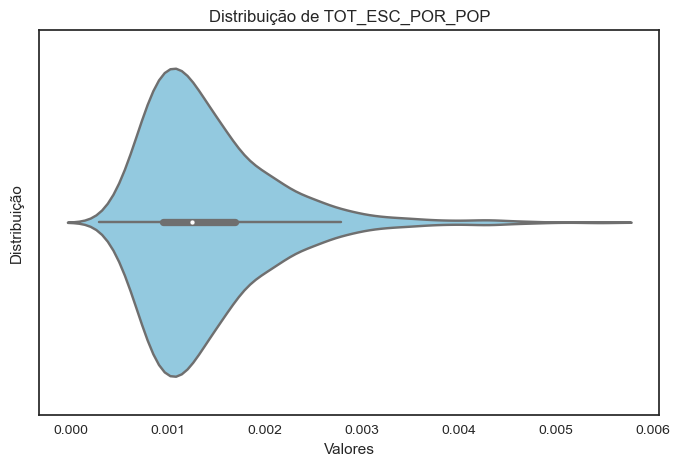

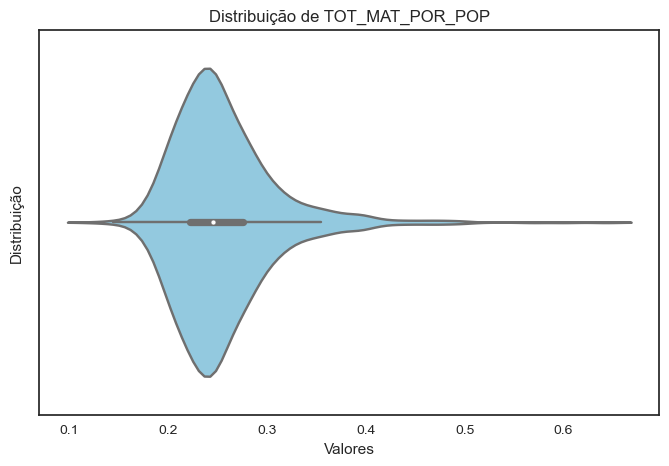

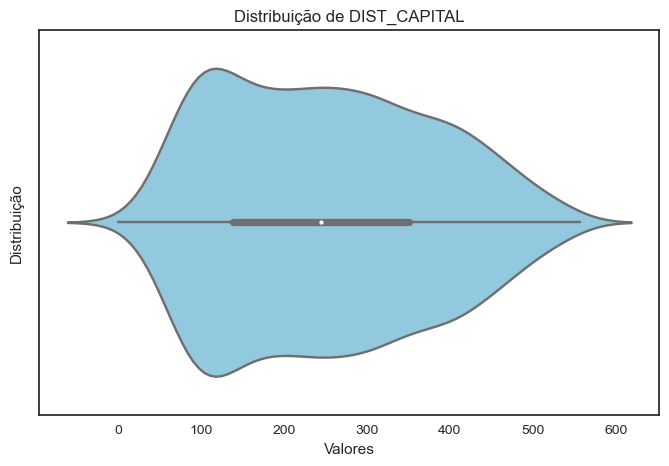

In [3]:
columns = [coluna for coluna in df.columns if (df[coluna].dtype == 'float64')&(coluna not in ['LATITUDE', 'LONGITUDE'])]

for column in columns:
    plt.figure(figsize=(8, 5))
    sns.violinplot(x=df[column], color='skyblue')
        
    plt.xlabel('Valores') 
    plt.ylabel('Distribuição')
    plt.title(f'Distribuição de {column}')
    plt.show()

# 3) Redução da dimensinalidade e análise de cluster

## 3.1) Pré-processamento

In [32]:
df_numeric_features = df[columns].copy()
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric_features)

## 3.2) Aplicação do PCA

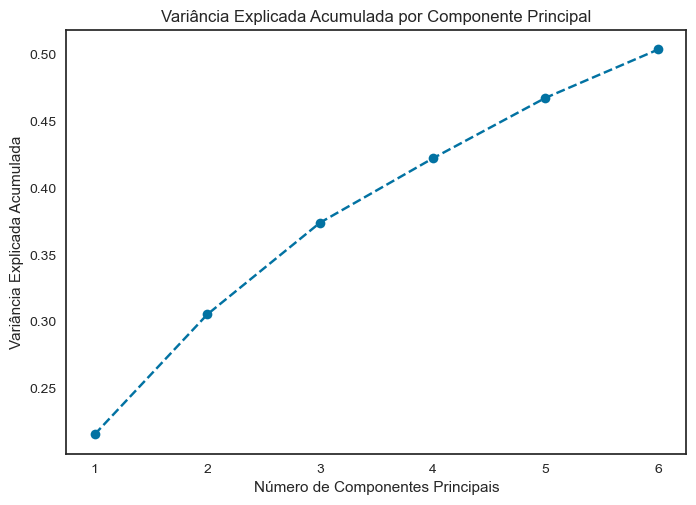

In [33]:
pca = PCA(n_components = 0.50)
df_reducted = pca.fit_transform(df_scaled)

variancia_explicada = pca.explained_variance_ratio_

variancia_acumulada = np.cumsum(variancia_explicada)
plt.plot(range(1, len(variancia_acumulada) + 1), variancia_acumulada, marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Variância Explicada Acumulada por Componente Principal')
plt.show()

## 3.3) Análise de cluster

In [34]:
PCA_plot = PCA(n_components=2, random_state=42)
df_components = PCA_plot.fit_transform(df_scaled)
df_components = pd.DataFrame(df_components)
df_components.columns = ['COMPONENT1', 'COMPONENT2']

def plot(df, df_components, clusters):
    df = pd.concat([df, df_components], axis = 1)
    df['CLUSTER'] = clusters

    actual_cities = df[
        [
            'NOME', 
            'COMPONENT1', 
            'COMPONENT2', 
            'CLUSTER'
        ]
    ].loc[
        df['NOME'].isin(
            [
                'MAURITI', 
                'SAO JOSE DA TAPERA', 
                'BUIQUE', 
                'INAJA'
            ]
        )
    ]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df, 
        x='COMPONENT1', 
        y='COMPONENT2', 
        hue='CLUSTER', 
        s=80,
    )
    sns.scatterplot(
        data=actual_cities, 
        x='COMPONENT1', 
        y='COMPONENT2', 
        marker = 'X', 
        color='black', 
        s=100, 
        label='Cidades atuais'
    )
    for i, row in actual_cities.iterrows():
        plt.text(row['COMPONENT1'] - 0.5, row['COMPONENT2'] + 0.5, row['NOME'], fontsize=10)
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.title('Visualização dos Grupos')
    sns.despine()
    plt.show()

### 3.3.2) K-Means

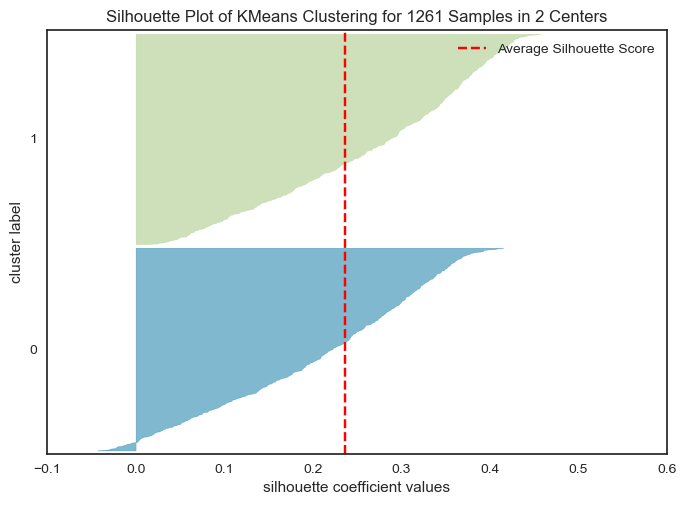

In [35]:
best_score = -1  
best_n_clusters = 0  
for n_clusters in range(2,10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(df_reducted)
    score = silhouette_score(df_reducted, clusters)
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters
        
silhouette_visualizer(KMeans(best_n_clusters, random_state=42), df_reducted, colors='yellowbrick')
plt.show()

Silhouette Score:  0.1926
Davies-Bouldin Score:  1.5281
Calinski-Harabasz Index:  305.5167


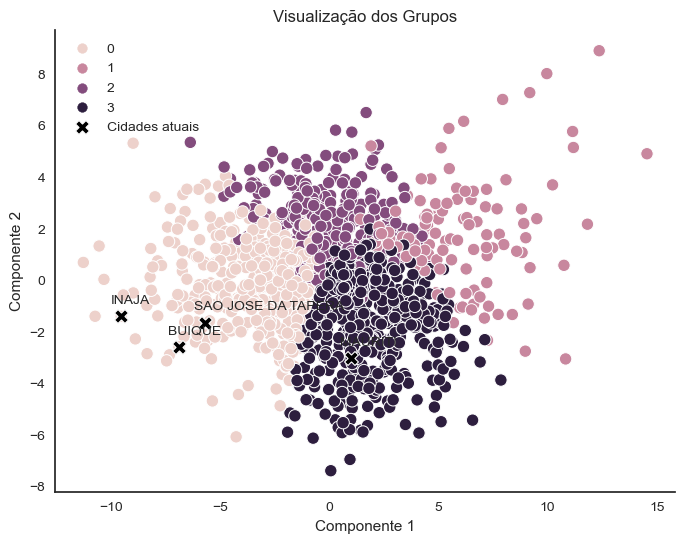

In [36]:
kmeans = KMeans(4, random_state = 42)
k_clusters = kmeans.fit_predict(df_reducted)
print('Silhouette Score: ',round(silhouette_score(df_reducted, k_clusters),4))
print('Davies-Bouldin Score: ',round(davies_bouldin_score(df_reducted, k_clusters),4))
print('Calinski-Harabasz Index: ',round(calinski_harabasz_score(df_reducted, k_clusters),4))
plot(df, df_components, k_clusters)

## 3.4) Seleção das melhores features

In [37]:
X = df[columns]
y = k_clusters

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf_model = RandomForestClassifier(n_jobs=-1, random_state=42)
boruta = BorutaPy(rf_model, n_estimators='auto', verbose=False, random_state=42)
boruta.fit(X_train.values, y_train)
mask_columns_selected = boruta.support_.tolist()
df_pp = X.iloc[:, mask_columns_selected]
columns_selected = df_pp.columns
columns_selected

Index(['DIST_EF_PUB', 'DIST_EM_PUB', 'IDEB_AI', 'IDEB_AF', 'DOCSUP_EF_PUB',
       'DOCSUP_EM_PUB', 'TXNASC7C', 'PINTERSAP', 'PDEFAGUA', 'PDEFESGOTO',
       'PIND_POS', 'SNIS_PAGUA', 'POP_TOT', 'PMATPUB_EF', 'PMATPUB_EM',
       'POP_TOT_30KM', 'TEMP_MED', 'AREA_IRRIGADA_TOT', 'AREA_IRRIGADA_POT',
       'AREA_IRRIGADA_POT_E', 'AREA_IRRIGADA_TOT_POT_E', 'IDHM', 'T_BANAGUA',
       'T_DENS', 'T_LUZ', 'AGUA_ESGOTO', 'PIND', 'PINDCRI', 'I_FREQ_PROP',
       'T_FBSUPER', 'T_ATRASO_1_BASICO', 'T_ATRASO_1_FUND', 'T_ATRASO_1_MED',
       'T_ATRASO_2_BASICO', 'T_ATRASO_2_FUND', 'T_ATRASO_2_MED',
       'T_ANALF11A14', 'T_ANALF15A17', 'T_ANALF15M', 'T_ANALF18A24',
       'T_ANALF18M', 'T_ANALF25A29', 'T_ANALF25M', 'RDPC', 'QUAL_MED_AGUA',
       'TRANSPORT_COST', 'TOT_ESC_POR_POP', 'DIST_CAPITAL'],
      dtype='object')

## 3.5) Pré-processamento

In [38]:
df_best_features = df[columns_selected].copy()
df_scaled = scaler.fit_transform(df_best_features)

## 3.6) Nova aplicação do PCA

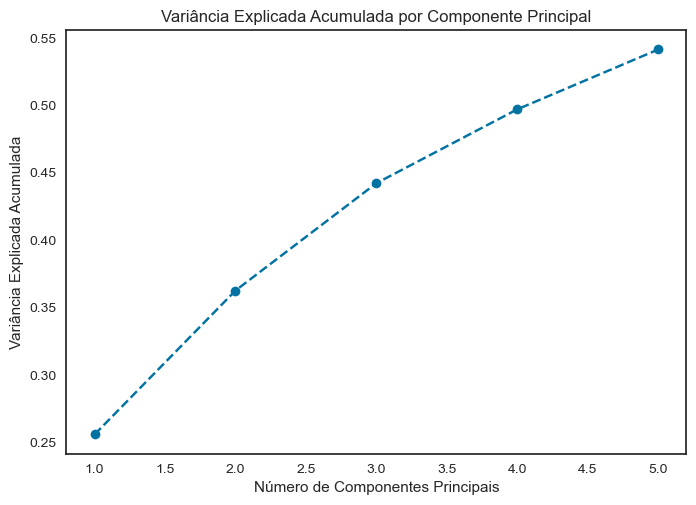

In [39]:
df_reducted = pca.fit_transform(df_scaled)

variancia_explicada = pca.explained_variance_ratio_

variancia_acumulada = np.cumsum(variancia_explicada)
plt.plot(range(1, len(variancia_acumulada) + 1), variancia_acumulada, marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Variância Explicada Acumulada por Componente Principal')
plt.show()

## 3.6) Nova análise de cluster

In [40]:
df_components = PCA_plot.fit_transform(df_scaled)
df_components = pd.DataFrame(df_components)
df_components.columns = ['COMPONENT1', 'COMPONENT2']

### 3.6.2) K-Means

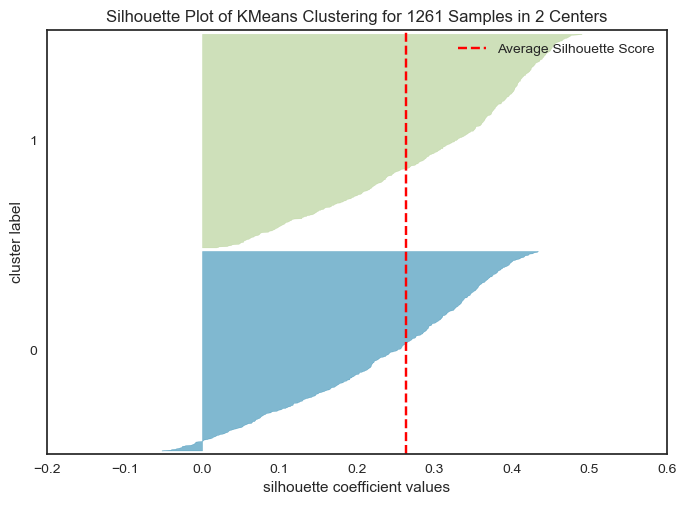

In [41]:
best_score = -1  
best_n_clusters = 0  
for n_clusters in range(2,10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(df_reducted)
    score = silhouette_score(df_reducted, clusters)
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters
        
silhouette_visualizer(KMeans(best_n_clusters, random_state=42), df_reducted, colors='yellowbrick')
plt.show()

Silhouette Score:  0.2175
Davies-Bouldin Score:  1.4022
Calinski-Harabasz Index:  365.5874


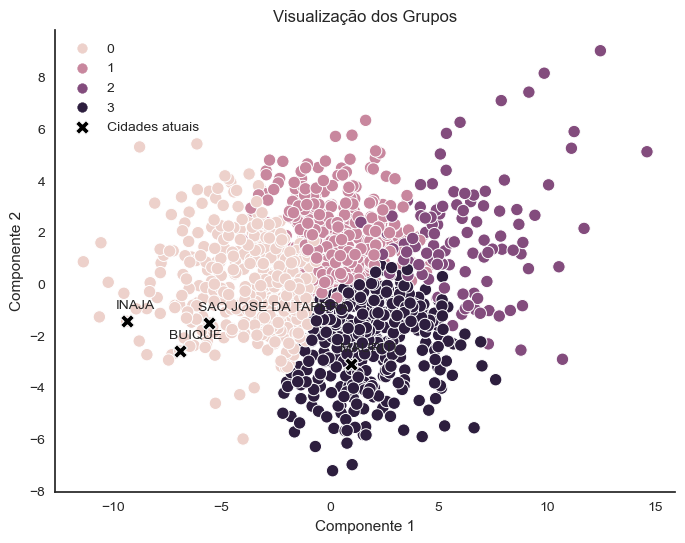

In [42]:
kmeans = KMeans(4, random_state = 42)
k_clusters = kmeans.fit_predict(df_reducted)
print('Silhouette Score: ',round(silhouette_score(df_reducted, k_clusters),4))
print('Davies-Bouldin Score: ',round(davies_bouldin_score(df_reducted, k_clusters),4))
print('Calinski-Harabasz Index: ',round(calinski_harabasz_score(df_reducted, k_clusters),4))
plot(df, df_components, k_clusters)

## 3.4) Seleção dos municípios com maior potencial

In [43]:
df['CLUSTER'] = k_clusters
df.to_csv('../Dados/Tabela_final/municipios_clusters.csv')

### 3.4.1) Interpretação dos municípios atuais

In [44]:
actual_cities = df[
    [
        'NOME', 
        'IDHM',
        'POP_TOT', 
        'POP_TOT_30KM',
        'RDPC', 
        'T_ANALF15M', 
        'I_FREQ_PROP', 
        'T_DES18M',
        'PIND',
        'CLUSTER'
    ]
].loc[df['NOME'].isin(['MAURITI', 'SAO JOSE DA TAPERA', 'BUIQUE', 'INAJA'])]

actual_cities

,NOME,IDHM,POP_TOT,POP_TOT_30KM,RDPC,T_ANALF15M,I_FREQ_PROP,T_DES18M,PIND,CLUSTER
34,SAO JOSE DA TAPERA,0.527,32258.8,225558.2,188.84,37.04,0.536,4.33,39.70,0
418,MAURITI,0.605,46103.4,207315.4,236.11,29.51,0.632,8.31,29.78,3
796,BUIQUE,0.527,56502.4,234399.4,176.76,40.18,0.524,7.25,38.73,0
827,INAJA,0.523,21917.0,89734.8,182.73,35.98,0.471,7.35,41.19,0


### 3.4.1) Filtro e interpretação dos clusters

In [45]:
df = pd.read_csv('../Dados/Tabela_final/municipios_clusters.csv')

df = df.loc[(df['POP_TOT'] >= 21917)&(df['POP_TOT_30KM'] >= 89734)]

df[
    [
        'CLUSTER',
        'IDHM',
        'POP_TOT', 
        'POP_TOT_30KM',
        'RDPC', 
        'T_ANALF15M', 
        'I_FREQ_PROP', 
        'T_DES18M',
        'PIND'
    ]
].groupby('CLUSTER').mean()

,IDHM,POP_TOT,POP_TOT_30KM,RDPC,T_ANALF15M,I_FREQ_PROP,T_DES18M,PIND
CLUSTER,,,,,,,,
0,0.556740,34770.004000,206204.252000,236.770600,33.833400,0.548820,6.681400,29.774400
1,0.594456,42114.978947,184916.954386,301.398772,24.462982,0.580070,8.359298,19.531053
2,0.667135,118351.156757,356075.300000,449.794595,18.020541,0.660568,8.775135,9.177027
3,0.618368,41083.876316,206024.373684,284.136316,26.726842,0.667263,6.891316,21.030000


In [46]:
df['CLUSTER'].value_counts()

3    76
2    74
1    57
0    50
Name: CLUSTER, dtype: int64

### 3.4.1) Seleção dos municipios de maior potencial

In [29]:
potential_muns = df.copy()

potential_muns = potential_muns[
    [
        'IBGE7',
        'NOME', 
        'UF',
        'IDHM',
        'RDPC', 
        'T_ANALF15M', 
        'I_FREQ_PROP', 
        'T_DES18M',
        'PIND',
        'IDEB_AI',
        'IDEB_AF',
        'POP_TOT_30KM',
        'POP_TOT'
    ]
].loc[
    (potential_muns['CLUSTER'] == 0)&
    ~(potential_muns['NOME'].isin(['MAURITI', 'SAO JOSE DA TAPERA', 'BUIQUE', 'INAJA']))
].sort_values(by='IDHM').reset_index().drop(columns='index')

potential_muns

,IBGE7,NOME,UF,IDHM,RDPC,T_ANALF15M,I_FREQ_PROP,T_DES18M,PIND,IDEB_AI,IDEB_AF,POP_TOT_30KM,POP_TOT
0,2916500,ITAPICURU,BA,0.486,185.70,38.52,0.462,9.86,31.44,3.912,2.784,197766.2,35881.0
1,2705002,MATA GRANDE,AL,0.504,186.87,38.79,0.499,1.57,41.39,4.152,3.260,129923.6,25555.2
2,2921500,MONTE SANTO,BA,0.506,197.43,35.57,0.494,4.55,35.11,3.796,3.036,107356.8,53678.4
3,2607505,ITAIBA,PE,0.510,218.32,39.73,0.497,4.11,27.48,4.104,3.268,129160.2,26440.2
4,2615805,TUPANATINGA,PE,0.519,172.52,38.41,0.513,5.31,45.08,5.200,3.564,135832.6,26445.0
5,2100907,ARAIOSES,MA,0.521,175.81,33.70,0.530,7.70,40.55,3.892,3.292,278943.2,45225.2
6,2603207,CAETES,PE,0.522,176.77,38.63,0.530,3.82,42.77,4.584,3.660,275058.0,28139.2
7,2702355,CRAIBAS,AL,0.525,199.54,39.67,0.554,2.73,30.89,4.000,2.916,452771.8,24250.4
8,2600500,AGUAS BELAS,PE,0.526,239.30,40.23,0.484,6.76,31.96,4.356,3.904,120915.8,42556.6
9,2805406,POCO REDONDO,SE,0.529,202.24,35.58,0.489,6.55,36.41,3.640,3.176,160430.8,33748.0


### 3.4.1) Identificação do município mais prioritário

In [31]:
scaler = MinMaxScaler()
best_mun = potential_muns.copy()
for column in ['IDHM','RDPC','I_FREQ_PROP','IDEB_AI','IDEB_AF']:
    best_mun[column] = 1/best_mun[column]
num_metrics = ['IDHM','RDPC', 'T_ANALF15M', 'I_FREQ_PROP', 'T_DES18M','PIND','IDEB_AI','IDEB_AF', 'POP_TOT_30KM','POP_TOT']
best_mun[num_metrics] = scaler.fit_transform(best_mun[num_metrics])
best_mun['SCORE'] = best_mun['RDPC'] + best_mun['PIND'] + best_mun['POP_TOT']
best_mun[num_metrics] = best_mun[num_metrics].rank(ascending=False)
best_mun.sort_values(by='SCORE', ascending= False).reset_index().drop(columns='index')

,IBGE7,NOME,UF,IDHM,RDPC,T_ANALF15M,I_FREQ_PROP,T_DES18M,PIND,IDEB_AI,IDEB_AF,POP_TOT_30KM,POP_TOT,SCORE
0,2902708,BARRA,BA,19.0,6.0,37.0,18.5,20.0,4.0,20.0,12.0,33.0,3.0,2.404857
1,2100907,ARAIOSES,MA,6.0,2.0,17.0,15.5,12.0,6.0,7.5,18.0,8.0,9.0,2.269401
2,2702900,GIRAU DO PONCIANO,AL,13.0,4.0,11.0,14.0,8.0,7.0,14.0,23.0,4.0,13.0,2.105179
3,2921500,MONTE SANTO,BA,3.0,9.0,13.0,6.0,31.0,9.0,5.0,5.0,34.0,4.0,2.048525
4,2709202,TRAIPU,AL,11.0,5.0,1.0,13.0,35.0,1.0,12.0,11.0,27.0,24.0,2.043566
5,2615805,TUPANATINGA,PE,5.0,1.0,8.0,11.0,26.0,2.0,37.0,24.0,23.0,26.0,2.034384
6,2603207,CAETES,PE,7.0,3.0,6.0,15.5,34.0,3.0,35.0,29.0,9.0,23.0,1.948780
7,2902104,ARACI,BA,12.0,13.0,15.0,2.0,22.0,12.0,1.5,7.0,20.0,2.0,1.769138
8,2705002,MATA GRANDE,AL,2.0,8.0,5.0,9.5,37.0,5.0,26.0,13.5,24.0,30.0,1.730945
9,2916500,ITAPICURU,BA,1.0,7.0,7.0,1.0,2.0,13.0,11.0,1.0,15.0,16.0,1.679553
